In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('../input/jena-climate-2009-2016/jena_climate_2009_2016.csv')

In [3]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
len(df)

420551

In [5]:
#Looks like there are no null values in the dataset
df.isna().sum()/100

Date Time          0.0
p (mbar)           0.0
T (degC)           0.0
Tpot (K)           0.0
Tdew (degC)        0.0
rh (%)             0.0
VPmax (mbar)       0.0
VPact (mbar)       0.0
VPdef (mbar)       0.0
sh (g/kg)          0.0
H2OC (mmol/mol)    0.0
rho (g/m**3)       0.0
wv (m/s)           0.0
max. wv (m/s)      0.0
wd (deg)           0.0
dtype: float64

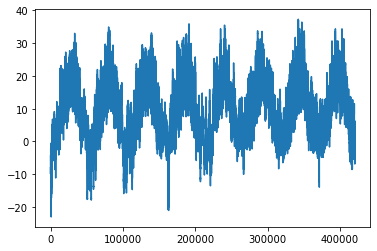

In [13]:
# On this plot, you can clearly see the yearly periodicity of temperature.

from matplotlib import pyplot as plt
%matplotlib inline

temp = df['T (degC)'].tolist()  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)




On this plot, you can see daily periodicity, especially evident for the last 4 days. We can also note that this ten-days period must be coming from a fairly cold winter month (based on the negatives values on y-axis)


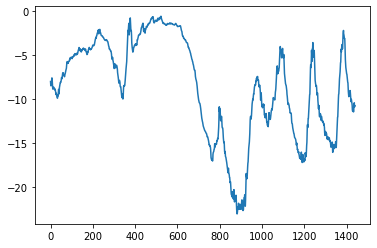

In [14]:
# Here is a more narrow plot of the first ten days of temperature data 
# (since the data is recorded every ten minutes, we get 144 data points per day):
#144 data points per day and we are visualizing for the first ten days     

plt.plot(range(1440), temp[:1440])


If we were trying to predict average temperature for the next month given a few month of past data, the problem would be easy, due to the reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. So is this timeseries predictable at a daily scale? Let's find out.

In [1]:
fname='../input/jena-climate-2009-2016/jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
# Let's convert all of these 420,551 lines of data into a Numpy array:

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [4]:
#Did not incldue the Date Time column
float_data.shape

(420551, 14)

Preparing the data

In [3]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Now here is the data generator that we will use. It yields a tuple (samples, targets) where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:

* data: The original array of floating point data, which we just normalized in the code snippet above.

* lookback: How many timesteps back should our input data go.

* delay: How many timesteps in the future should our target be.

* min_index and max_index: Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another one for testing.

* shuffle: Whether to shuffle our samples or draw them in chronological order.

* batch_size: The number of samples per batch.

* step: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [4]:
#Data generator

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [5]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

A common sense, non-machine learning baseline

In our case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common sense approach would be to always predict that the temperature 24 hours from now will be equal to the temperature right now. Let's evaluate this approach, using the Mean Absolute Error metric (MAE). Mean Absolute Error is simply equal to: np.mean(np.abs(preds - targets))

In [6]:
# Here's our evaluation loop:

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


It yields a MAE of 0.29. Since our temperature data has been normalized to be centered on 0 and have a standard deviation of one, this number is not immediately interpretable. It translates to an average absolute error of 0.29 * temperature_std degrees Celsius, i.e. 2.57˚C. That's a fairly large average absolute error -- now the game is to leverage our knowledge of deep learning to do better.

A basic machine learning approach

In [7]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/20
500/500 [==============================] - 18s 37ms/step - loss: 1.3729 - val_loss: 0.7854
Epoch 2/20
500/500 [==============================] - 17s 33ms/step - loss: 0.4433 - val_loss: 0.3066
Epoch 3/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2858 - val_loss: 0.3216
Epoch 4/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2644 - val_loss: 0.3250
Epoch 5/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2507 - val_loss: 0.3386
Epoch 6/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2431 - val_loss: 0.3105
Epoch 7/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2369 - val_loss: 0.3256
Epoch 8/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2317 - val_loss: 0.3506
Epoch 9/20
500/500 [==============================] - 17s 33ms/step - loss: 0.2279 - val_loss: 0.3553
Epoch 10/20
500/500 [==============================] - 17s 35ms/step - loss: 0.223

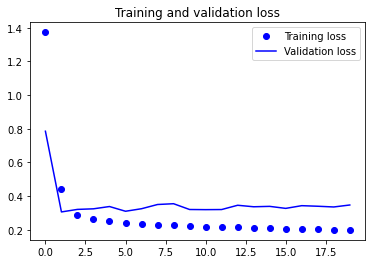

In [8]:
# Let's display the loss curves for validation and training:

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The validation MAE before we start overfitting, although not significantly high, is in the range (approx.) above 0.29. There is not much gain with re to reducing the validation loss.